In [1]:
import pandas as pd
import numpy as np
import json
import time

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [2]:
df_labels= 'data.info.txt'
df_labels = pd.read_csv(df_labels, delimiter=',')

df_raw = 'dataset0.json'

# Open the file and read line by line (each line = one read)
with open(df_raw, 'r') as file:
    data_list = []
    for line in file:
        try:
            data = json.loads(line)  # Parse each line as a separate JSON object
            data_list.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line: {line}")
            print(f"Error message: {e}")

In [3]:
df_labels['transcript_position'].astype(int)
print(df_labels[0:5])

           gene_id    transcript_id  transcript_position  label
0  ENSG00000004059  ENST00000000233                  244      0
1  ENSG00000004059  ENST00000000233                  261      0
2  ENSG00000004059  ENST00000000233                  316      0
3  ENSG00000004059  ENST00000000233                  332      0
4  ENSG00000004059  ENST00000000233                  368      0


In [4]:
datapoint_zero = []
datapoint_one = []
start = time.time()
for datapoint in data_list:
    for tId, tPos in datapoint.items():
        specific_transcript_id = tId
        for pos, seq in tPos.items():
            specific_transcript_position = int(pos)
            for _, bag in seq.items():
                measurements = bag
    filtered_label = df_labels[(df_labels['transcript_id'] == specific_transcript_id) & 
                    (df_labels['transcript_position'] == specific_transcript_position)]['label']
    if len(filtered_label) != 1:
        print(f"Anomaly with {specific_transcript_id} at {specific_transcript_position} position, found {len(filtered_label)} matches")
    if filtered_label.iloc[0] == 0:
        datapoint_zero.append(measurements)
    else:
        datapoint_one.append(measurements)
print(f"process took {time.time() - start :2f}")

process took 940.101961


0


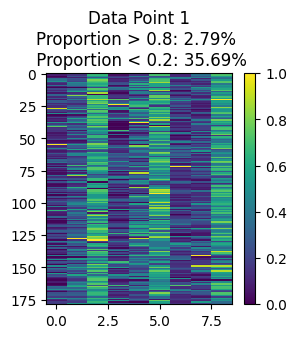

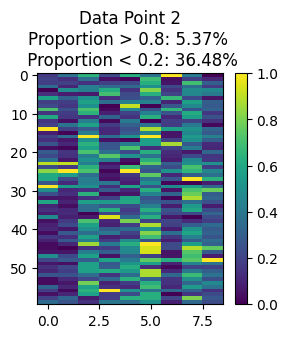

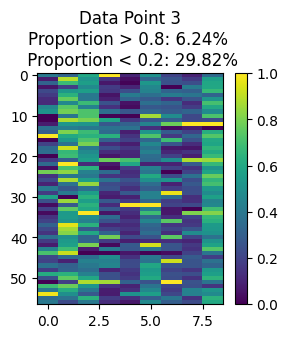

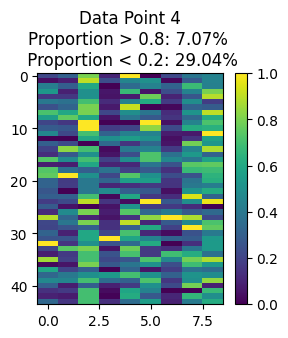

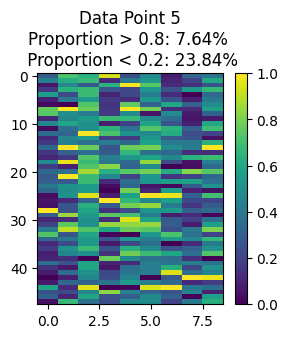

In [5]:
import matplotlib.pyplot as plt
index_groups = [
    [0, 3, 6],  # Group 1
    [1, 4, 7],  # Group 2
    [2, 5, 8]   # Group 3
]
# Plotting each data point as an image
normalized_data_one = []
for i, dp in enumerate(datapoint_one[0:5]):
    dp_array = np.array(dp)
    for indices in index_groups:
        min_vals = np.min(dp_array[:, indices], axis=0)
        max_vals = np.max(dp_array[:, indices], axis=0)
        range_vals = np.where(max_vals > min_vals, max_vals - min_vals, 1)
        
        # Normalize specific indices within each group
        for idx, feature_index in enumerate(indices):
            dp_array[:, feature_index] = (dp_array[:, feature_index] - min_vals[idx]) / range_vals[idx]
    normalized_dp = dp_array
    normalized_data_one.append(normalized_dp.flatten())
    if i%1000 == 0:
        print(i)
    # Counting values greater than 0.8
    count_high_values = np.sum(normalized_dp > 0.8)
    total_values = normalized_dp.size 
    proportion_high_values = count_high_values / total_values

    # Counting values lesser than 0.2
    count_low_values = np.sum(normalized_dp < 0.2)
    proportion_low_values = count_low_values / total_values

    plt.figure(figsize=(3, 3))  # Adjust figure size to your preference
    plt.imshow(normalized_dp, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.title(f'Data Point {i+1}\nProportion > 0.8: {proportion_high_values:.2%} \n Proportion < 0.2: {proportion_low_values:.2%}')
    plt.colorbar()
    plt.show()

0


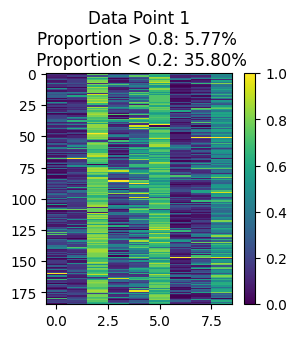

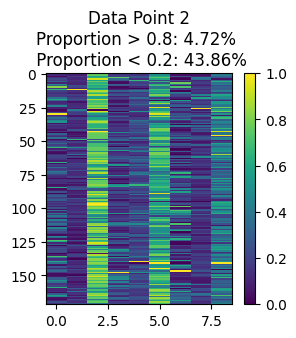

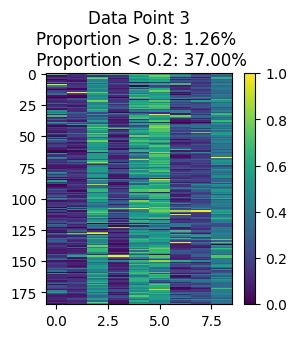

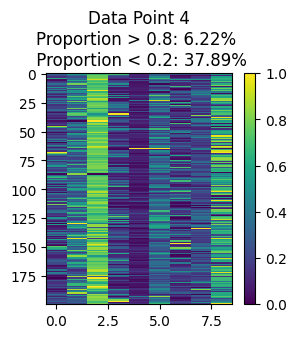

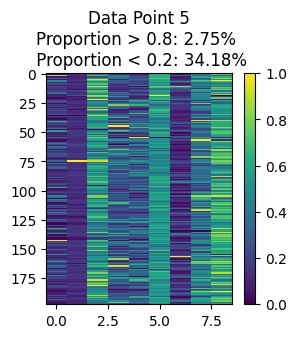

In [6]:
import matplotlib.pyplot as plt
index_groups = [
    [0, 3, 6],  # Group 1
    [1, 4, 7],  # Group 2
    [2, 5, 8]   # Group 3
]
# Plotting each data point as an image
normalized_data_zero = []
for i, dp in enumerate(datapoint_zero[0:5]):
    dp_array = np.array(dp)
    for indices in index_groups:
        min_vals = np.min(dp_array[:, indices], axis=0)
        max_vals = np.max(dp_array[:, indices], axis=0)
        range_vals = np.where(max_vals > min_vals, max_vals - min_vals, 1)
        
        # Normalize specific indices within each group
        for idx, feature_index in enumerate(indices):
            dp_array[:, feature_index] = (dp_array[:, feature_index] - min_vals[idx]) / range_vals[idx]
    normalized_dp = dp_array
    normalized_data_zero.append(normalized_dp.flatten())
    if i%1000 == 0:
        print(i)

    # Counting values greater than 0.8
    count_high_values = np.sum(normalized_dp > 0.8)
    total_values = normalized_dp.size 
    proportion_high_values = count_high_values / total_values

    # Counting values lesser than 0.2
    count_low_values = np.sum(normalized_dp < 0.2)
    proportion_low_values = count_low_values / total_values

    plt.figure(figsize=(3, 3))  # Adjust figure size to your preference
    plt.imshow(normalized_dp, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.title(f'Data Point {i+1}\nProportion > 0.8: {proportion_high_values:.2%} \n Proportion < 0.2: {proportion_low_values:.2%}')
    plt.colorbar()
    plt.show()

In [116]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.metrics import AUC
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Combine and label the data
data = normalized_data_one + normalized_data_zero
labels = [1]*len(normalized_data_one) + [0]*len(normalized_data_zero)

# Pad data to the longest sequence
data_padded = pad_sequences(data, padding='post', dtype='float32', value=0.0)
print("Shape of data after padding:", data_padded.shape)
# Convert labels to a numpy array
labels = np.array(labels)

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

X_train, X_test, y_train, y_test = train_test_split(data_padded, labels, test_size=0.2, random_state=42)

sequence_length = 8919 // 9  

X_train = X_train.reshape(-1, sequence_length, 9)
X_test = X_test.reshape(-1, sequence_length, 9)


Shape of data after padding: (121838, 8919)


In [117]:
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(sequence_length, 9)),
    MaxPooling1D(pool_size=2),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', 
                metrics=['accuracy', AUC(name='prc', curve='PR'), AUC(name='roc', curve='ROC')])
model.summary() 


c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)              │ (None, 989, 32)        │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 494, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

In [115]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Number of features after padding:", data_padded.shape[-1])


Shape of X_train: (97470, 8919)
Shape of X_test: (24368, 8919)
Number of features after padding: 8919


In [118]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, class_weight=class_weights_dict)


Epoch 1/10
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7933 - loss: 0.6783 - prc: 0.0435 - roc: 0.5024 - val_accuracy: 0.9044 - val_loss: 0.6716 - val_prc: 0.0576 - val_roc: 0.5805
Epoch 2/10
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6712 - loss: 0.6860 - prc: 0.0523 - roc: 0.5474 - val_accuracy: 0.8080 - val_loss: 0.6467 - val_prc: 0.0626 - val_roc: 0.6082
Epoch 3/10
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6657 - loss: 0.6758 - prc: 0.0585 - roc: 0.5925 - val_accuracy: 0.6833 - val_loss: 0.6381 - val_prc: 0.0652 - val_roc: 0.6160
Epoch 4/10
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5809 - loss: 0.6745 - prc: 0.0660 - roc: 0.6172 - val_accuracy: 0.6049 - val_loss: 0.6606 - val_prc: 0.0668 - val_roc: 0.6196
Epoch 5/10
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5913 - loss: 0.6652 - prc: 0.0657 - roc: 0.6268 - val_accuracy: 0.5562 - val_loss: 0.6669 - val_prc: 0.0703 - val_roc: 0.6314
Epoch 6/10
2437/2437 ━━━━━━━━

In [120]:
test_loss, test_acc = model.evaluate(X_test, y_test)
# print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

762/762 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5903 - loss: 0.6735 - prc: 0.1452 - roc: 0.7598


ValueError: too many values to unpack (expected 2)